In [1]:
# If using Google Colab, check this...
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from helper_functions import print_train_time
from timeit import default_timer as timer

In [3]:
# Check for GPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Get data from TensorFlow Keras Datasets

In [4]:
# Get data from tf.keras.datasets
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
train_images[0], train_labels[0]

(array([[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],
 
        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],
 
        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],
 
        ...,
 
        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333

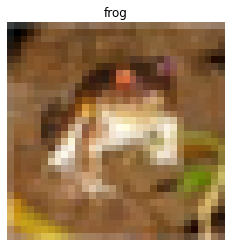

In [7]:
plt.imshow(train_images[0])
plt.title(class_names[int(train_labels[0])])
plt.axis(False);

In [8]:
# Create datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Make datasets faster
BATCH_SIZE = 128
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset, len(train_dataset), len(test_dataset)

2021-11-14 16:22:02.219350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-14 16:22:02.219489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


(<PrefetchDataset shapes: ((None, 32, 32, 3), (None, 1)), types: (tf.float64, tf.uint8)>,
 <PrefetchDataset shapes: ((None, 32, 32, 3), (None, 1)), types: (tf.float64, tf.uint8)>,
 391,
 79)

## Build a model 

In [ ]:
# Start time
start_time = timer()

# Set random seed
tf.random.set_seed(42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(32, 32, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation="softmax") # multi-class activation output
])

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # since labels aren't one-hot, use sparse_categorical_crossentropy
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit model 
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=len(train_dataset),
                    validation_data=test_dataset,
                    validation_steps=len(test_dataset))

end_time = timer()
print_train_time(start_time, end_time, device="Apple M1 Max")

Epoch 1/10


2021-11-14 16:22:03.706296: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-14 16:22:03.707454: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-14 16:22:03.707541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


390/391 [============================>.] - ETA: 0s - loss: 1.8038 - accuracy: 0.3383

2021-11-14 16:22:10.826616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


391/391 [==============================] - 8s 12ms/step - loss: 1.8037 - accuracy: 0.3384 - val_loss: 1.6161 - val_accuracy: 0.4071
Epoch 2/10
391/391 [==============================] - 5s 12ms/step - loss: 1.5390 - accuracy: 0.4430 - val_loss: 1.4903 - val_accuracy: 0.4605
Epoch 3/10
391/391 [==============================] - 5s 12ms/step - loss: 1.4348 - accuracy: 0.4831 - val_loss: 1.4028 - val_accuracy: 0.4946
Epoch 4/10
391/391 [==============================] - 5s 12ms/step - loss: 1.3703 - accuracy: 0.5094 - val_loss: 1.3467 - val_accuracy: 0.5136
Epoch 5/10
391/391 [==============================] - 5s 12ms/step - loss: 1.3201 - accuracy: 0.5296 - val_loss: 1.3054 - val_accuracy: 0.5325
Epoch 6/10
391/391 [==============================] - 5s 12ms/step - loss: 1.2810 - accuracy: 0.5452 - val_loss: 1.2768 - val_accuracy: 0.5464
Epoch 7/10
391/391 [==============================] - 5s 12ms/step - loss: 1.2501 - accuracy: 0.5577 - val_loss: 1.2533 - val_accuracy: 0.5568
Epoch 8/10

In [ ]:
# ## On Apple's M1 Max with Batch Size 32
# Epoch 1/10
# 2021-11-14 15:52:01.133800: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
# 2021-11-14 15:52:01.134861: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
# 2021-11-14 15:52:01.134947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
# 1563/1563 [==============================] - ETA: 0s - loss: 1.6948 - accuracy: 0.3803
# 2021-11-14 15:52:16.892279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
# 1563/1563 [==============================] - 17s 9ms/step - loss: 1.6948 - accuracy: 0.3803 - val_loss: 1.5826 - val_accuracy: 0.4305
# Epoch 2/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 1.4219 - accuracy: 0.4903 - val_loss: 1.3601 - val_accuracy: 0.5139
# Epoch 3/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 1.3089 - accuracy: 0.5338 - val_loss: 1.2657 - val_accuracy: 0.5494
# Epoch 4/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 1.2336 - accuracy: 0.5617 - val_loss: 1.1981 - val_accuracy: 0.5758
# Epoch 5/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 1.1778 - accuracy: 0.5827 - val_loss: 1.1566 - val_accuracy: 0.5919
# Epoch 6/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 1.1367 - accuracy: 0.5998 - val_loss: 1.1174 - val_accuracy: 0.6042
# Epoch 7/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 1.1066 - accuracy: 0.6111 - val_loss: 1.0853 - val_accuracy: 0.6202
# Epoch 8/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 1.0820 - accuracy: 0.6215 - val_loss: 1.0696 - val_accuracy: 0.6234
# Epoch 9/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 1.0605 - accuracy: 0.6286 - val_loss: 1.0539 - val_accuracy: 0.6279
# Epoch 10/10
# 1563/1563 [==============================] - 14s 9ms/step - loss: 1.0418 - accuracy: 0.6334 - val_loss: 1.0437 - val_accuracy: 0.6326

# Train time on Apple M1 Max: 145.284 seconds
# Out[12]:
# 145.28421195800001



# ## On Apple's baseline M1 Pro w/ 16GB Ram and batch size 32
# Epoch 1/10
#    6/1563 [..............................] - ETA: 17s - loss: 2.3021 - accuracy: 0.1510 
# 2021-11-14 12:08:34.099293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
# 1563/1563 [==============================] - ETA: 0s - loss: 1.6939 - accuracy: 0.3804
# 2021-11-14 12:08:48.422142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
# 1563/1563 [==============================] - 16s 10ms/step - loss: 1.6939 - accuracy: 0.3804 - val_loss: 1.5820 - val_accuracy: 0.4313
# Epoch 2/10
# 1563/1563 [==============================] - 15s 9ms/step - loss: 1.4214 - accuracy: 0.4923 - val_loss: 1.3688 - val_accuracy: 0.5121
# Epoch 3/10
# 1563/1563 [==============================] - 15s 9ms/step - loss: 1.3070 - accuracy: 0.5337 - val_loss: 1.2805 - val_accuracy: 0.5437
# Epoch 4/10
# 1563/1563 [==============================] - 15s 10ms/step - loss: 1.2338 - accuracy: 0.5621 - val_loss: 1.2175 - val_accuracy: 0.5617
# Epoch 5/10
# 1563/1563 [==============================] - 15s 9ms/step - loss: 1.1817 - accuracy: 0.5840 - val_loss: 1.1679 - val_accuracy: 0.5804
# Epoch 6/10
# 1563/1563 [==============================] - 15s 9ms/step - loss: 1.1391 - accuracy: 0.6004 - val_loss: 1.1279 - val_accuracy: 0.5966
# Epoch 7/10
# 1563/1563 [==============================] - 15s 9ms/step - loss: 1.1055 - accuracy: 0.6125 - val_loss: 1.0945 - val_accuracy: 0.6088
# Epoch 8/10
# 1563/1563 [==============================] - 15s 10ms/step - loss: 1.0796 - accuracy: 0.6217 - val_loss: 1.0751 - val_accuracy: 0.6214
# Epoch 9/10
# 1563/1563 [==============================] - 15s 9ms/step - loss: 1.0579 - accuracy: 0.6293 - val_loss: 1.0559 - val_accuracy: 0.6259
# Epoch 10/10
# 1563/1563 [==============================] - 15s 10ms/step - loss: 1.0399 - accuracy: 0.6355 - val_loss: 1.0431 - val_accuracy: 0.6290

# Train time on Apple M1 Pro: 150.183 seconds
# Out[15]:
# 150.18279237499996


# ## Apple M1 Pro with Batch Size 128
# Epoch 1/10
# 2021-11-14 12:57:56.257185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
# 2021-11-14 12:57:56.258498: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
# 2021-11-14 12:57:56.258581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
# 391/391 [==============================] - ETA: 0s - loss: 1.8037 - accuracy: 0.3384
# 2021-11-14 12:58:03.646585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
# 391/391 [==============================] - 8s 13ms/step - loss: 1.8037 - accuracy: 0.3384 - val_loss: 1.6161 - val_accuracy: 0.4071
# Epoch 2/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.5390 - accuracy: 0.4430 - val_loss: 1.4903 - val_accuracy: 0.4605
# Epoch 3/10
# 391/391 [==============================] - 5s 13ms/step - loss: 1.4348 - accuracy: 0.4831 - val_loss: 1.4028 - val_accuracy: 0.4946
# Epoch 4/10
# 391/391 [==============================] - 5s 13ms/step - loss: 1.3703 - accuracy: 0.5094 - val_loss: 1.3467 - val_accuracy: 0.5136
# Epoch 5/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.3201 - accuracy: 0.5296 - val_loss: 1.3054 - val_accuracy: 0.5325
# Epoch 6/10
# 391/391 [==============================] - 5s 13ms/step - loss: 1.2810 - accuracy: 0.5452 - val_loss: 1.2768 - val_accuracy: 0.5464
# Epoch 7/10
# 391/391 [==============================] - 5s 13ms/step - loss: 1.2501 - accuracy: 0.5577 - val_loss: 1.2533 - val_accuracy: 0.5568
# Epoch 8/10
# 391/391 [==============================] - 5s 13ms/step - loss: 1.2249 - accuracy: 0.5671 - val_loss: 1.2309 - val_accuracy: 0.5653
# Epoch 9/10
# 391/391 [==============================] - 5s 13ms/step - loss: 1.2029 - accuracy: 0.5751 - val_loss: 1.2133 - val_accuracy: 0.5738
# Epoch 10/10
# 391/391 [==============================] - 5s 13ms/step - loss: 1.1826 - accuracy: 0.5825 - val_loss: 1.1930 - val_accuracy: 0.5789

# Train time on Apple M1 Pro: 54.861 seconds
# Out[13]:
# 54.861148458


# ## Apple M1 Max with Batch Size 128
# Epoch 1/10
#   1/391 [..............................] - ETA: 2:09 - loss: 2.3014 - accuracy: 0.1641
# 2021-11-14 15:57:38.791170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
# 2021-11-14 15:57:38.792192: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
# 2021-11-14 15:57:38.792253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
# 389/391 [============================>.] - ETA: 0s - loss: 1.8048 - accuracy: 0.3379
# 2021-11-14 15:57:43.154718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
# 391/391 [==============================] - 5s 12ms/step - loss: 1.8037 - accuracy: 0.3384 - val_loss: 1.6161 - val_accuracy: 0.4071
# Epoch 2/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.5390 - accuracy: 0.4430 - val_loss: 1.4903 - val_accuracy: 0.4605
# Epoch 3/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.4348 - accuracy: 0.4831 - val_loss: 1.4028 - val_accuracy: 0.4946
# Epoch 4/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.3703 - accuracy: 0.5094 - val_loss: 1.3467 - val_accuracy: 0.5136
# Epoch 5/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.3201 - accuracy: 0.5296 - val_loss: 1.3054 - val_accuracy: 0.5325
# Epoch 6/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.2810 - accuracy: 0.5452 - val_loss: 1.2768 - val_accuracy: 0.5464
# Epoch 7/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.2501 - accuracy: 0.5577 - val_loss: 1.2533 - val_accuracy: 0.5568
# Epoch 8/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.2249 - accuracy: 0.5671 - val_loss: 1.2309 - val_accuracy: 0.5653
# Epoch 9/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.2029 - accuracy: 0.5751 - val_loss: 1.2133 - val_accuracy: 0.5738
# Epoch 10/10
# 391/391 [==============================] - 5s 12ms/step - loss: 1.1826 - accuracy: 0.5825 - val_loss: 1.1930 - val_accuracy: 0.5789

# Train time on Apple M1 Max: 47.751 seconds
# Out[10]:
# 47.75110683300001